This notebook provides an example on how to use `LensingETC` to setup an optimization of observing strategies with two filters. We are going to use 2 *HST* filters: one in IR and one in UVIS.

# Import modules

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
import lenstronomy.Util.kernel_util as kernel_util

## Load PSFs

We are loading IR and UVIS PSFs that are simulated with `tinytim`. We use a `lenstronomy` function to degrade the sampling resolution of the simulated IR PSF by a factor of 3 to use in modeling. It's up to the user to decide whether to use supersampled or non-supersampled PSF to use in modeling, it's recommended to use a supersampled PSF for simulation, and the PSF resolution that would be available for the actual data is to be used for modeling.

In [2]:
f160w_psf_hires = fits.getdata('psf/wfc3_f160w_hires00_psf.fits')
f200lp_psf = fits.getdata('psf/wfc3_200lp00_psf.fits')

f160w_psf = kernel_util.degrade_kernel(f160w_psf_hires, degrading_factor=3)[1:62, 1:62]

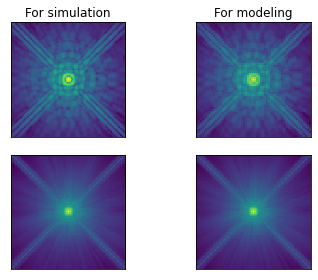

In [3]:
simulation_psfs = [f160w_psf_hires, f200lp_psf]
modeling_psfs = [f160w_psf, f200lp_psf]

fig, axes = plt.subplots(ncols=2, nrows=len(simulation_psfs))

for i in range(len(simulation_psfs)):
    axes[i, 0].matshow(np.log10(simulation_psfs[i]))
    axes[i, 1].matshow(np.log10(modeling_psfs[i]))
    
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    
axes[0, 0].set_title('For simulation')
axes[0, 1].set_title('For modeling')

fig.tight_layout()

## Provide specifications for lens, filters, and observations

Here, we set up the specifications for lens sample, filters, and observations.

In [4]:
lens_specifications = {
    'num_lenses': 5,
    'with_point_source': False
}


# Specify the filter and detector characteristics
# the values here correspond to WFC3 F140W and F200LP, respectively
filter_specifications = {
    'num_filter': 2, # number of filters to simulate
    
    'read_noise': [14, 3],
    # https://www.stsci.edu/itt/review/ihb_cy18/WFC3/c05_detector8.html#358383
    # https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2015/WFC3-2015-13.pdf
    
    'ccd_gain': [1., 1.5],
    
    'sky_brightness': [
        -2.5 * np.log10(1.93e-18 * 3.34e4 *  14000**2 / 3631), # F140W
        -2.5 * np.log10(7.72e-18 * 3.34e4 *  5500**2 / 3631), # F200LP
    ],
    
    'magnitude_zero_point': [26.450, 27.336], 
    # https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/ir-photometric-calibration
    # https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration
    
    'seeing': [None, None],
    'pixel_scale': [0.08, 0.04],
    'num_pixel': [60, 120],
    'simulation_psf_supersampling_resolution': [3, 1],
    'modeling_psf_supersampling_resolution': [1, 1],
    'simulation_shapelet_n_max': [4, 8], # higher n_max allows more structure, max is 50
    'modeling_shapelet_n_max': [4, 8], # higher n_max allows more structure, max is 50
    # I recommend not to go over n_max = 10 for modeling, otherwise computation may take too long.
    # For simulation, the appropriate n_max can be chosen by looking at the simulated images and 
    # adjusting it accordingly to achieve the desired level of structures. Since simulation is done only once, 
    # n_max for simulation will not impact the overall computation time.
}

# different observing scenarios
# must include exposure_times and num_exposures for each filter
observing_scenarios = [
    # scenario 1
    {'exposure_time': [300, 300], # exposure time per frame
     'num_exposure': [3, 1],  # number of exposures to combine
     'simulate_cosmic_ray': [1.2e-3, 2.4e-3] # bool (default hit count: 2.4e-3/arcsec^2/s), or CR hit count / arcsec^2 / s
     # whether to simulate cosmic ray hits, will randomly create weighted exposure time map
     # if single exposure, then pixels hit by cosmic ray will be masked

    },
    
    # scenario 2
    {'exposure_time': [300, 300], 
     'num_exposure': [2, 2], 
     'simulate_cosmic_ray': [1.2e-3, 2.4e-3]
    },
    
    # scenario 3
    {'exposure_time': [200, 300], 
     'num_exposure': [3, 2], 
     'simulate_cosmic_ray': [1.2e-3, 2.4e-3]
    },
]


# dictionary containing PSFs
psfs = {
    'simulation': simulation_psfs,
    'modeling': modeling_psfs,
    'psf_uncertainty_level': 0.50, 
    # 50% uncertainty in modeling psfs, only applied for point source modeling, optional, default is 0.5.
}

Here, we specify the magnitude distributions for the deflector, source, and point source. The distribution needs to be a callable that will return a magnitude value.

In [5]:
from scipy import stats

# distribution function for lens and source magnitudes
lens_magnitude_distributions = lambda: np.random.normal(18.5, 0.15) + np.array([0, np.random.normal(2.7, .2)])

source_magnitude_distributions = lambda: np.random.normal(20.8, 0.08) + np.array([0., np.random.normal(2., .2)])

quasar_magnitude_distributions = lambda: np.random.uniform(20, 21) + np.array([0., np.random.uniform(0.5, 1.2)])

magnitude_distributions = {
    'lens': lens_magnitude_distributions,
    'source': source_magnitude_distributions,
    'quasar': quasar_magnitude_distributions
}

## Simulate data

Now, we create the `LensingETC` instance, that will simulate the data at initiation based on the provided specifications. 

(It is also possible to create a `LensingETC` instance without providing any argument, which can be used for loading and plotting outputs without creating simulated lenses when creating the object instance.)

In [6]:
from lensing_etc import LensingETC

lensing_etc = LensingETC(lens_specifications, filter_specifications, observing_scenarios,
                      psfs, magnitude_distributions, use_pemd=False, 
                      source_galaxy_indices=[40, 30, 8, 15, 34, 21, 19, 25, 69, 2, 53, 78],
                      # A list of indices can be provided to select specific galaxy morphologies
                      # as sources, this list can be curated by inspecting the galaxy structures with
                      # the notebook source_galaxies/Inspect source galaxy structure.ipynb.
                      # If source_galaxy_indices=None, then source galaxies wll be randomly selected.
                     )
    

Check the simulated lenes.

/Users/ajshajib/Dropbox/LensingETC/lensing_etc.py:370: RuntimeWarning: invalid value encountered in log10
  np.log10(self.simulated_data[j][n][i]),


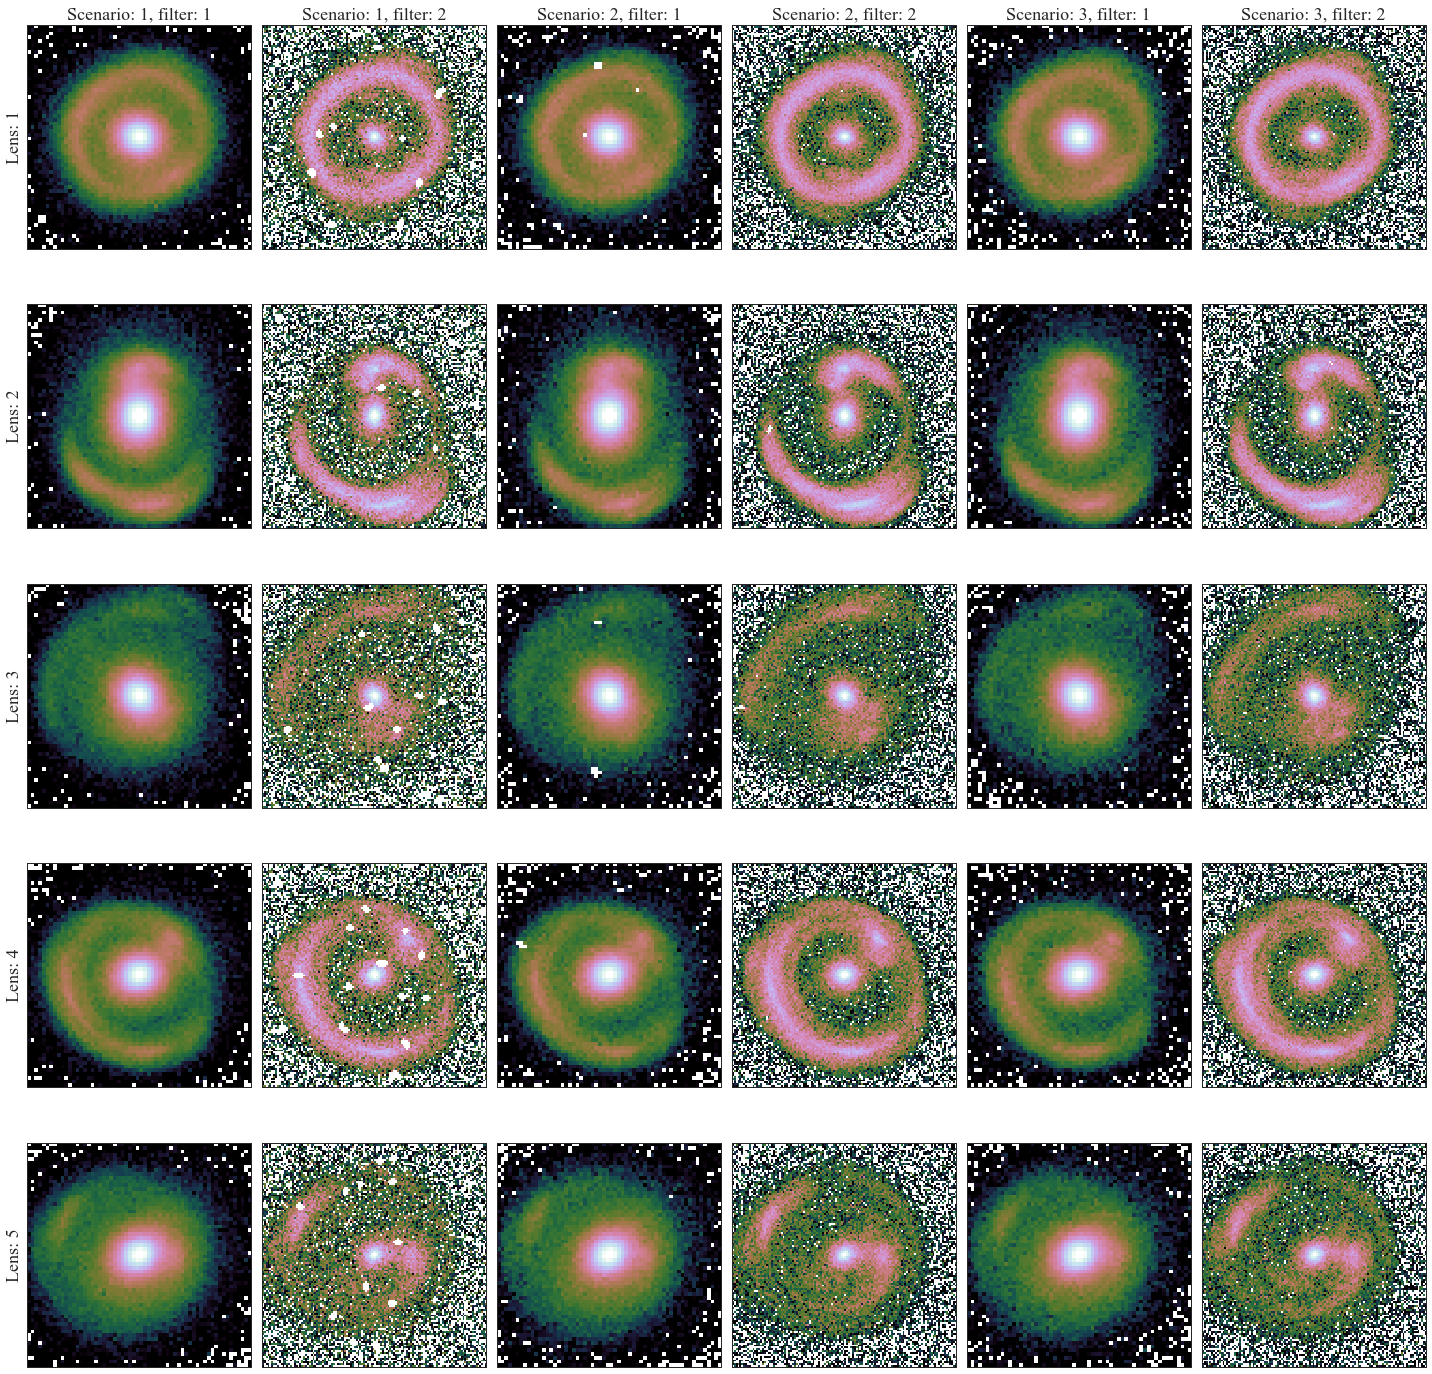

In [7]:
%matplotlib inline

lensing_etc.plot_simualated_data(vmin=[-1, -2], vmax=[1, 0], figsize=(20, 20));

We can also plot the effective exposure time maps for each image to check the impact of cosmic ray hits.

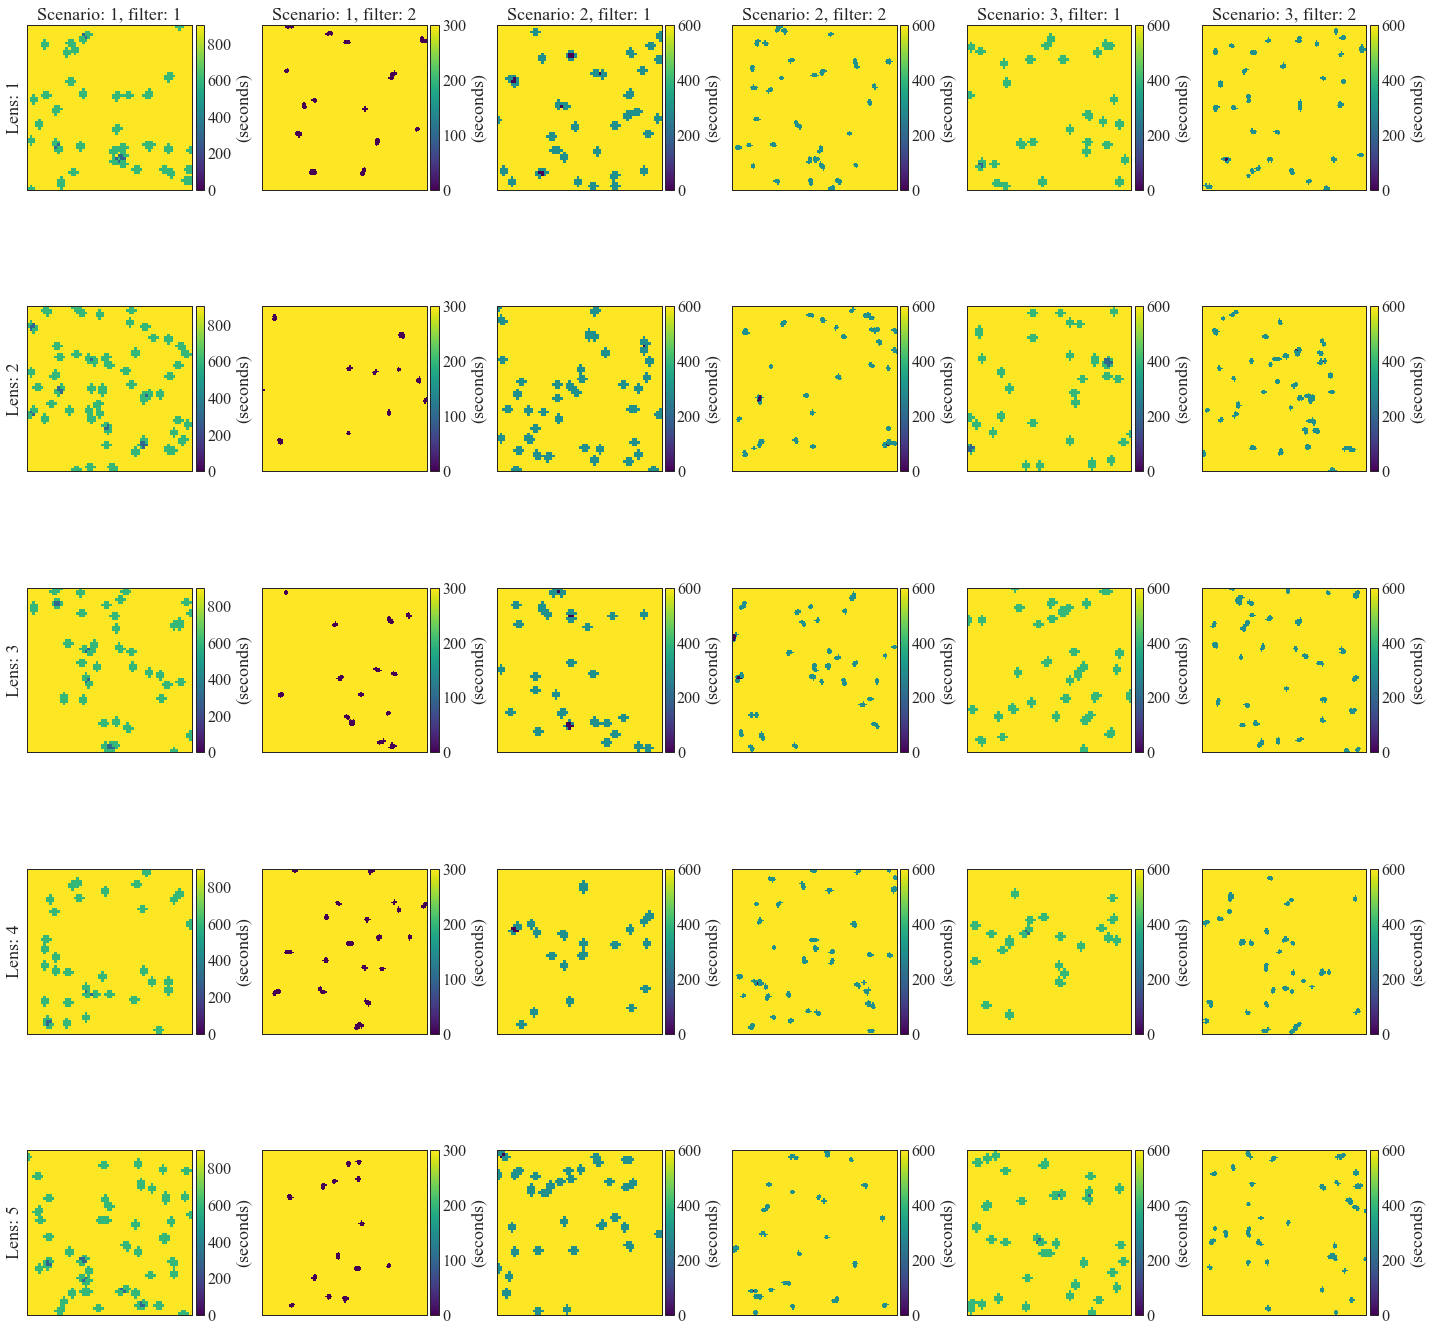

In [8]:
lensing_etc.plot_exposure_maps(figsize=(20, 20));

## Run lens models

This following cell will run the modeling on all of the simulated images (for all combinations of lens and observing scenarios/cases.) This cell will take the longest to finish computing.

In [9]:
lensing_etc.fit_models(run_id='hst_snap', num_threads=8, n_run=700)

Running lens: 1/5, scenario: 1/3


100%|██████████| 700/700 [1:04:39<00:00,  5.54s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3887.978720188141 time taken for MCMC sampling
Running lens: 1/5, scenario: 2/3


100%|██████████| 700/700 [1:04:19<00:00,  5.51s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3866.400605916977 time taken for MCMC sampling
Running lens: 1/5, scenario: 3/3


100%|██████████| 700/700 [1:04:25<00:00,  5.52s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3873.8618426322937 time taken for MCMC sampling
Running lens: 2/5, scenario: 1/3


100%|██████████| 700/700 [1:05:45<00:00,  5.64s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3952.9717226028442 time taken for MCMC sampling
Running lens: 2/5, scenario: 2/3


100%|██████████| 700/700 [1:06:45<00:00,  5.72s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
4013.2249734401703 time taken for MCMC sampling
Running lens: 2/5, scenario: 3/3


100%|██████████| 700/700 [1:05:18<00:00,  5.60s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3925.982199907303 time taken for MCMC sampling
Running lens: 3/5, scenario: 1/3


100%|██████████| 700/700 [1:04:03<00:00,  5.49s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3851.927912712097 time taken for MCMC sampling
Running lens: 3/5, scenario: 2/3


100%|██████████| 700/700 [1:06:44<00:00,  5.72s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
4011.7741515636444 time taken for MCMC sampling
Running lens: 3/5, scenario: 3/3


100%|██████████| 700/700 [1:06:33<00:00,  5.71s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
4001.247586965561 time taken for MCMC sampling
Running lens: 4/5, scenario: 1/3


100%|██████████| 700/700 [1:04:15<00:00,  5.51s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3863.058026075363 time taken for MCMC sampling
Running lens: 4/5, scenario: 2/3


100%|██████████| 700/700 [1:04:36<00:00,  5.54s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3885.1861321926117 time taken for MCMC sampling
Running lens: 4/5, scenario: 3/3


100%|██████████| 700/700 [1:06:43<00:00,  5.72s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
4010.6721501350403 time taken for MCMC sampling
Running lens: 5/5, scenario: 1/3


100%|██████████| 700/700 [1:05:14<00:00,  5.59s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3922.058634519577 time taken for MCMC sampling
Running lens: 5/5, scenario: 2/3


100%|██████████| 700/700 [1:03:38<00:00,  5.46s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3827.124376296997 time taken for MCMC sampling
Running lens: 5/5, scenario: 3/3


100%|██████████| 700/700 [1:04:03<00:00,  5.49s/it]

Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 700
3852.9083111286163 time taken for MCMC sampling


## Assess model outputs and compare observing strategies

You can check the best fit lens models for a combination of lens and observation strategy.

-1.1075619265662406 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.1717392214345972
reduced chi^2 of data  1 =  1.0912087087345534


/Users/ajshajib/PyCharm Projects/lenstronomy/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/Users/ajshajib/PyCharm Projects/lenstronomy/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


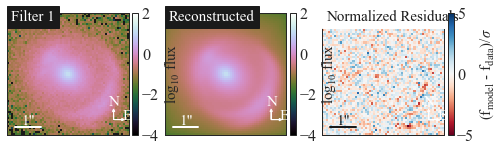

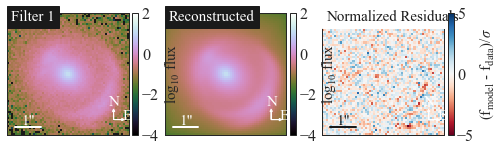

In [9]:
lensing_etc.plot_lens_models('hst_snap', 0, 0)

Here, we plot the MCMC trace plot to check for convergence.

N_step: 700, N_walkers: 128, N_params: 16
theta_E_lens0 1.3861 ± 0.0020
gamma_lens0 1.9772 ± 0.0181
e1_lens0 0.0628 ± 0.0046
e2_lens0 -0.1052 ± 0.0062
gamma1_lens1 0.0429 ± 0.0027
gamma2_lens1 -0.0388 ± 0.0042
beta_source_light0 0.1457 ± 0.0026
center_x_source_light0 0.2788 ± 0.0077
center_y_source_light0 -0.2947 ± 0.0071
R_sersic_lens_light0 1.3525 ± 0.0381
n_sersic_lens_light0 4.7036 ± 0.0745
e1_lens_light0 0.0814 ± 0.0026
e2_lens_light0 -0.1109 ± 0.0028
center_x_lens_light0 -0.0365 ± 0.0006
center_y_lens_light0 -0.0364 ± 0.0005
R_sersic_lens_light1 1.7752 ± 0.0932


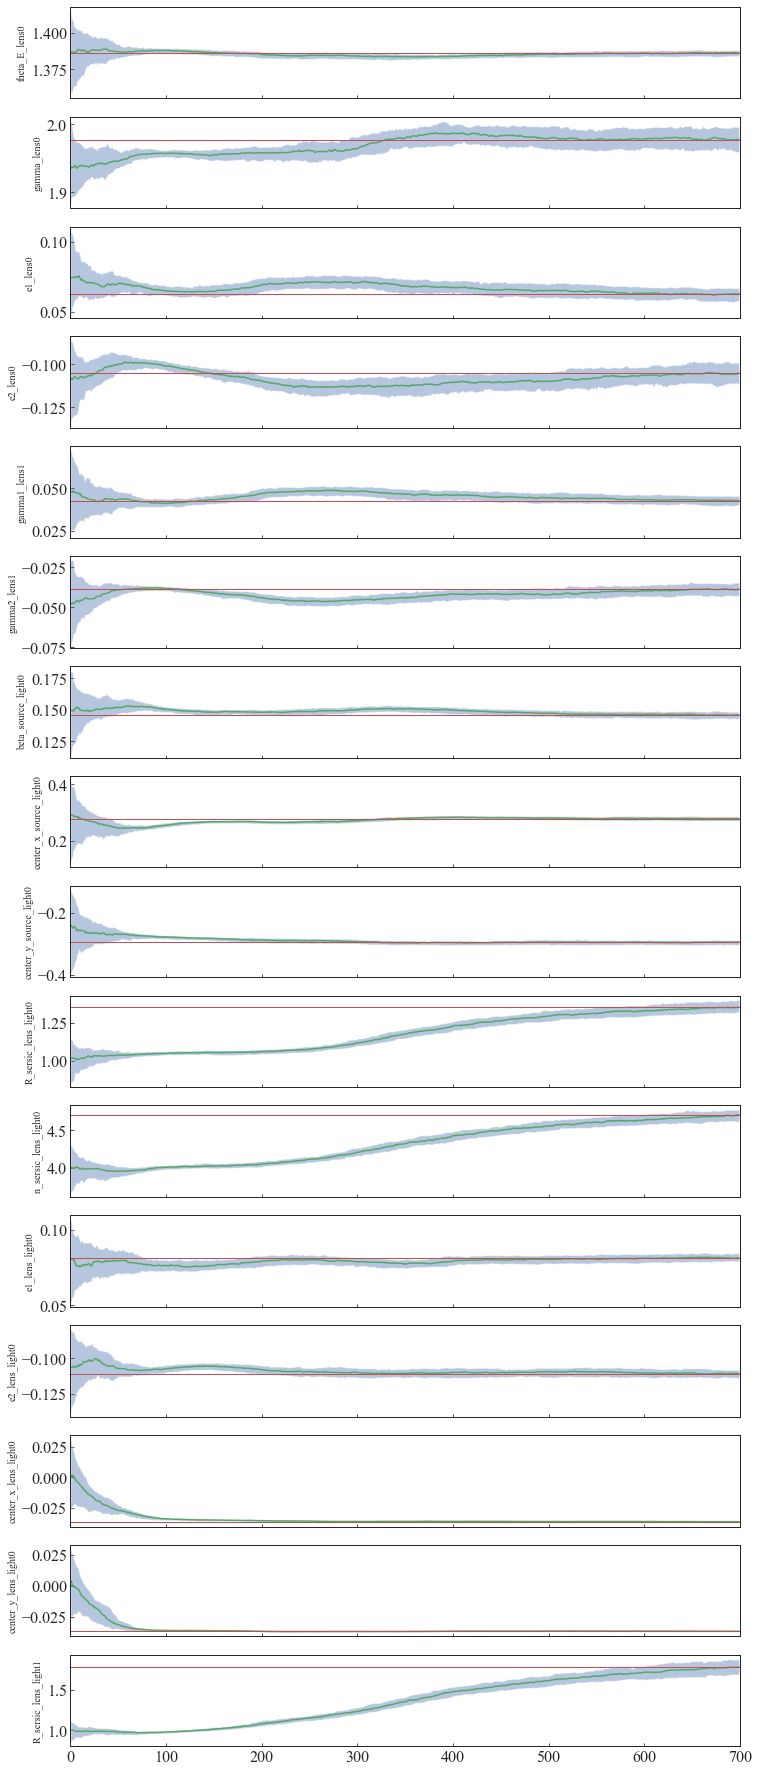

In [10]:
lensing_etc.plot_mcmc_trace('hst_snap', 0, 2);

If the MCMC chains haven't converged, they can be extended, as done below.

In [15]:
lensing_etc.extend_chains(num_lenses=5, num_scenarios=3, run_id='hst_snap', extend_id='1', 
                          num_threads=8, n_run=200)

Running lens: 1/5, scenario: 1/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:28<00:00,  5.54s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1115.8514609336853 time taken for MCMC sampling
Running lens: 1/5, scenario: 2/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:44<00:00,  5.62s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1132.7502310276031 time taken for MCMC sampling
Running lens: 1/5, scenario: 3/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:35<00:00,  5.58s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1124.1123836040497 time taken for MCMC sampling
Running lens: 2/5, scenario: 1/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [19:02<00:00,  5.71s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1151.0868921279907 time taken for MCMC sampling
Running lens: 2/5, scenario: 2/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:44<00:00,  5.62s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1132.5610597133636 time taken for MCMC sampling
Running lens: 2/5, scenario: 3/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:49<00:00,  5.65s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1137.530574798584 time taken for MCMC sampling
Running lens: 3/5, scenario: 1/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [19:00<00:00,  5.70s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1147.6607797145844 time taken for MCMC sampling
Running lens: 3/5, scenario: 2/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:23<00:00,  5.52s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1111.5579760074615 time taken for MCMC sampling
Running lens: 3/5, scenario: 3/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [17:53<00:00,  5.37s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1082.5876533985138 time taken for MCMC sampling
Running lens: 4/5, scenario: 1/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:42<00:00,  5.61s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1130.0567843914032 time taken for MCMC sampling
Running lens: 4/5, scenario: 2/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [18:52<00:00,  5.66s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1140.229026556015 time taken for MCMC sampling
Running lens: 4/5, scenario: 3/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [19:00<00:00,  5.70s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1149.174154996872 time taken for MCMC sampling
Running lens: 5/5, scenario: 1/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [17:22<00:00,  5.21s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1049.9580054283142 time taken for MCMC sampling
Running lens: 5/5, scenario: 2/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [17:44<00:00,  5.32s/it]


Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1072.6976673603058 time taken for MCMC sampling
Running lens: 5/5, scenario: 3/3
N_step: 700, N_walkers: 128, N_params: 16
re-using previous samples to initialize the next MCMC run.


100%|██████████| 200/200 [17:31<00:00,  5.26s/it]

Computing the MCMC...
Number of walkers =  128
Burn-in iterations:  0
Sampling iterations (in current run): 200
1059.1553626060486 time taken for MCMC sampling


Here, we are plotting the comparison of recovered lens model parameters and their uncertainties. You can plot the comparison for both single lenses, and for sample averages.

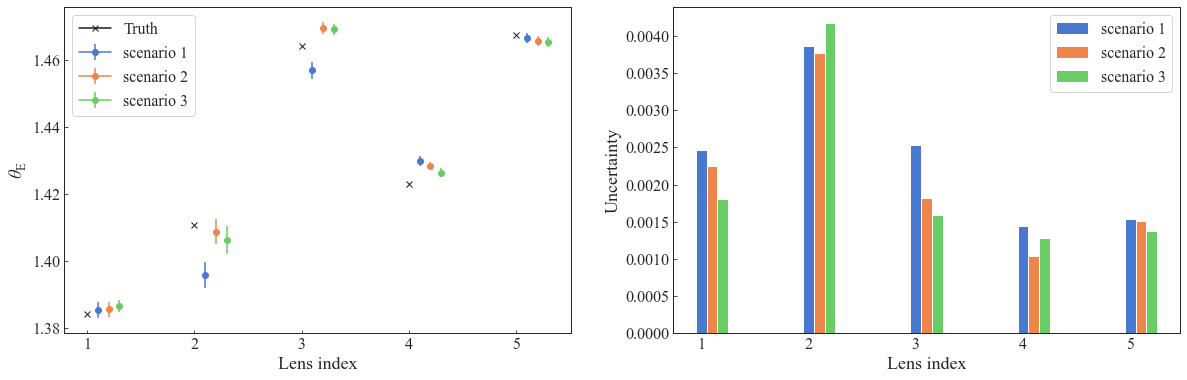

In [16]:
lensing_etc.plot_parameter_posterior_comparison('theta_E', 'hst_snap1', 5, 3);

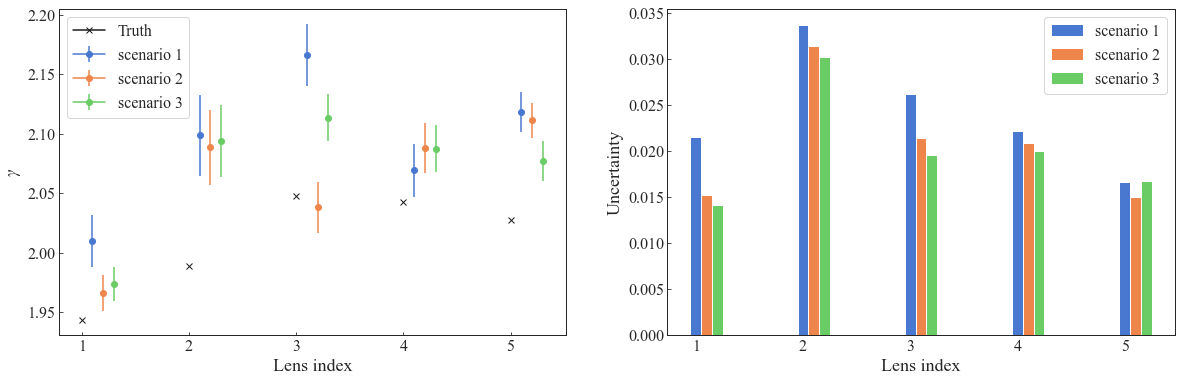

In [17]:
lensing_etc.plot_parameter_posterior_comparison('gamma', 'hst_snap1', 5, 3);

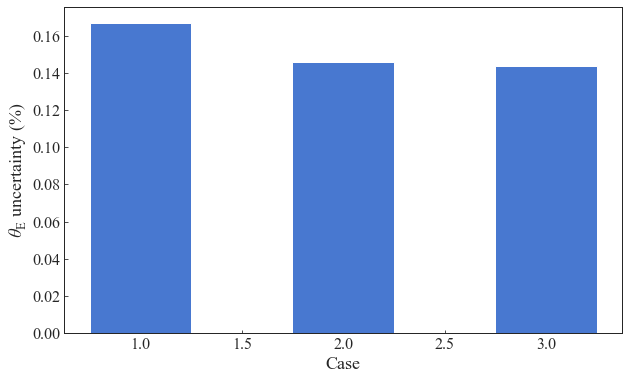

In [21]:
lensing_etc.plot_scenario_comparison('theta_E', 'hst_snap1', num_lenses=5, num_scenarios=3);

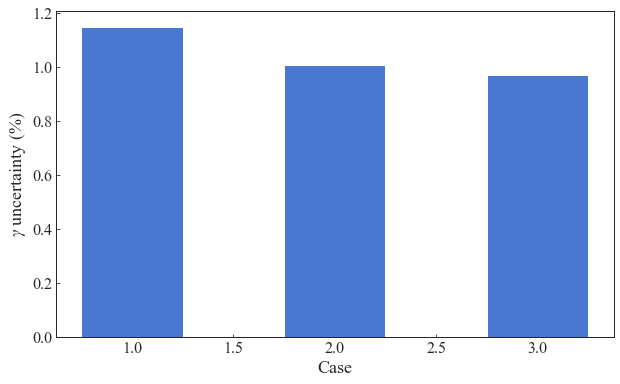

In [20]:
lensing_etc.plot_scenario_comparison('gamma', 'hst_snap1', num_lenses=5, num_scenarios=3);